In [1]:
! pip install ./python_files
from python_files import *
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available, training on: ", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

Processing c:\users\tbird\documents\github\06-665-psm-final-project\python_files
  Created wheel for python-files: filename=python_files-0.1.0-py3-none-any.whl size=1023 sha256=817757ce9f6dff30a99e281407bfe5ef91d71ebe3190d74fbf8abe824952017a
  Stored in directory: C:\Users\tbird\AppData\Local\Temp\pip-ephem-wheel-cache-9l2z18vc\wheels\ca\c1\3d\7f33f532b3f9eddd59bbd2ddd1f7583d50a6829274a8d07efa
Successfully built python-files
  Attempting uninstall: python-files
    Found existing installation: python-files 0.1.0
    Uninstalling python-files-0.1.0:
      Successfully uninstalled python-files-0.1.0


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


GPU is available, training on:  NVIDIA GeForce RTX 2070 Super with Max-Q Design


# NN Training and Testing

### Getting data for the NN training and testing

In [2]:
# loading data from saved folder
solutions = np.load("./saved/100_solutions.npy")
F_ag_array = np.load("./saved/100_F_ag.npy")
test_solutions = np.load("./saved/10test_solutions.npy")
test_F_ag_array = np.load("./saved/10test_F_ag.npy")
num_timesteps = 500
# Concatenating training data before preprocessing
solutions_w_F_ag = np.concatenate((solutions, F_ag_array.reshape(100,1,num_timesteps)), axis=1)
# Preprocessing training data
train_data = data_preprocessing(solutions_w_F_ag, N = 100, num_timesteps = num_timesteps, batch_size = 1, shuffle = False)
print("Training data preprocessing done")
# Concatenating test data before preprocessing
test_solutions_w_F_ag = np.concatenate((test_solutions, test_F_ag_array.reshape(10,1,num_timesteps)), axis=1)
# Preprocessing test data
test_data = data_preprocessing(test_solutions_w_F_ag, N = 10, num_timesteps = num_timesteps, batch_size = 1, shuffle = False)
print("Test data preprocessing done")

pre-processing data with N = 100
Training data preprocessing done
pre-processing data with N = 10
Test data preprocessing done


### The following block only needs to be used if new data is needed

In [3]:

# N = 100
# solutions_name = str(N) + "_solutions.npy"
# F_ag_array_name = str(N) + "_F_ag.npy"
# save_dir = "./saved"
# os.makedirs (save_dir, exist_ok=True)

# num_timesteps = 500
# train_random_inputs = generate_inputs (N)
# solutions, F_ag_array = generate_ode_data(train_random_inputs, num_timesteps)

# print ("="*50)
# print ("Saved: ")
# print (f"{solutions_name}: {solutions.shape}")
# print (f"{F_ag_array_name}: {F_ag_array.shape}")
# print ("="*50)

# # SAVE
# np.save (join(save_dir, solutions_name), solutions)
# np.save (join(save_dir, F_ag_array_name), F_ag_array)

# # PLOT
# plot_ode_solutions (solutions)
# plot_input_output(F_ag_array, solutions, N)


### Training and test the NN (2 hidden layers, 64 neurons, 20 epochs)

Epoch 1 | Epoch mean training loss for a single simulation = 23.445818902755903
Epoch 1 | Epoch mean test loss for a single simulation = 0.6864352274438247


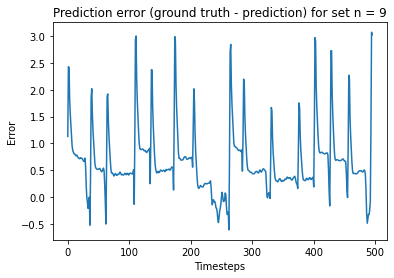

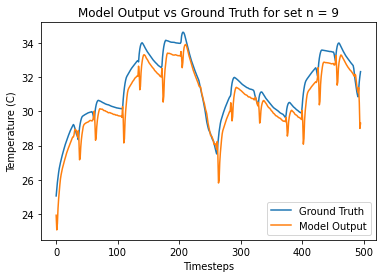

Epoch 2 | Epoch mean training loss for a single simulation = 13.581631076231938
Epoch 2 | Epoch mean test loss for a single simulation = 0.028067633278119654


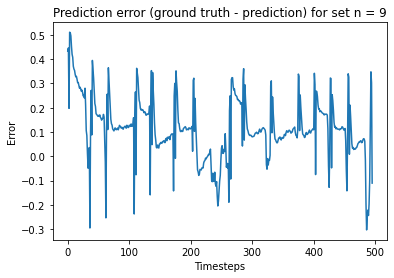

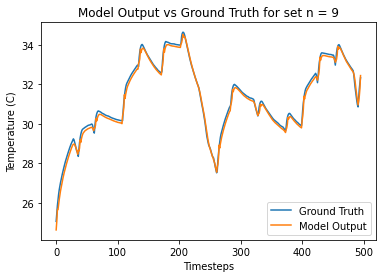

Epoch 3 | Epoch mean training loss for a single simulation = 10.112833594680275
Epoch 3 | Epoch mean test loss for a single simulation = 0.07401581864274528


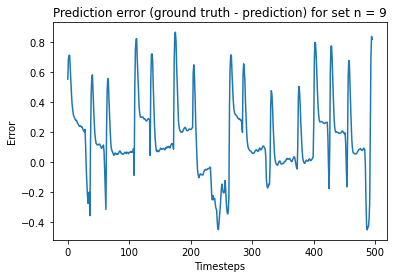

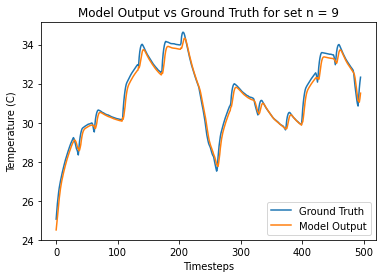

Epoch 4 | Epoch mean training loss for a single simulation = 8.338780456271708
Epoch 4 | Epoch mean test loss for a single simulation = 0.029780950829304098


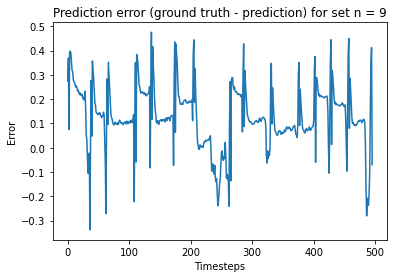

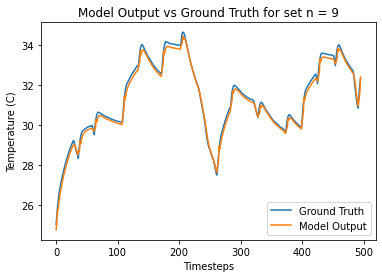

Epoch 5 | Epoch mean training loss for a single simulation = 7.198461626282746
Epoch 5 | Epoch mean test loss for a single simulation = 0.5055435398293118


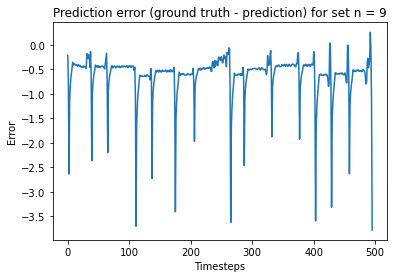

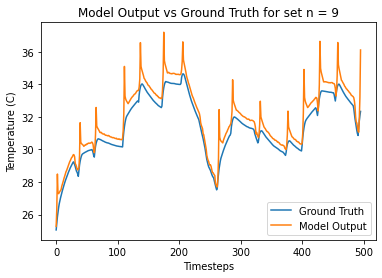

Epoch 6 | Epoch mean training loss for a single simulation = 6.5233899438639495
Epoch 6 | Epoch mean test loss for a single simulation = 0.08803467261492307


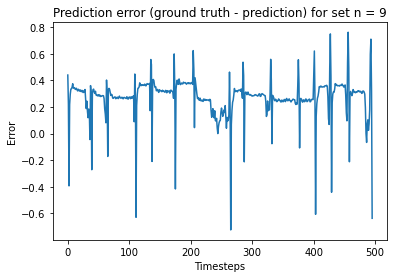

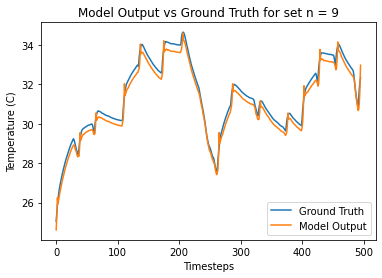

Epoch 7 | Epoch mean training loss for a single simulation = 6.000198682860765
Epoch 7 | Epoch mean test loss for a single simulation = 0.02052601945826844


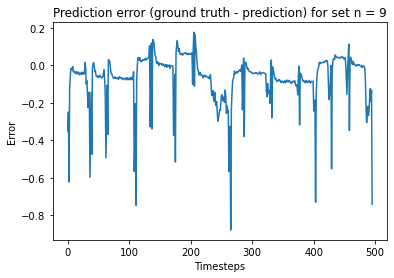

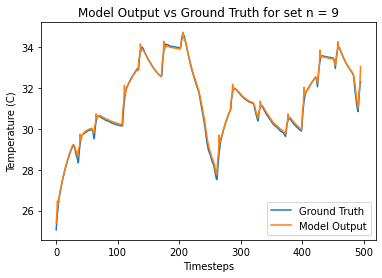

Epoch 8 | Epoch mean training loss for a single simulation = 5.615425101520343
Epoch 8 | Epoch mean test loss for a single simulation = 0.9813706011010049


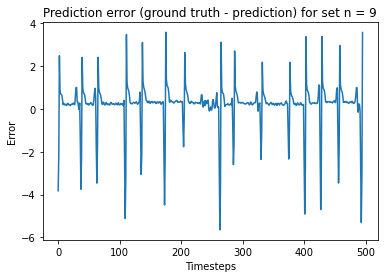

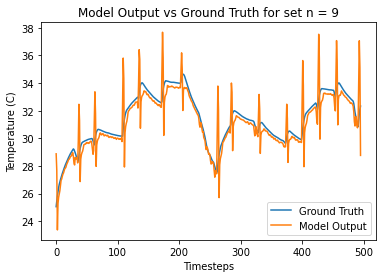

Epoch 9 | Epoch mean training loss for a single simulation = 5.2822292816875756
Epoch 9 | Epoch mean test loss for a single simulation = 0.5387541019000983


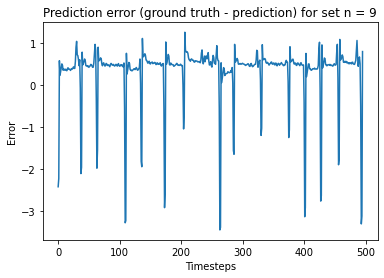

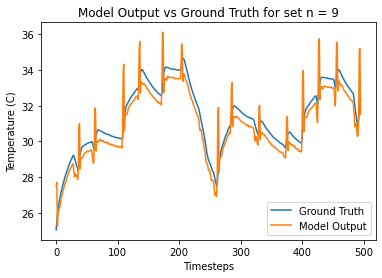

Epoch 10 | Epoch mean training loss for a single simulation = 5.033424428634248
Epoch 10 | Epoch mean test loss for a single simulation = 0.12522751640381985


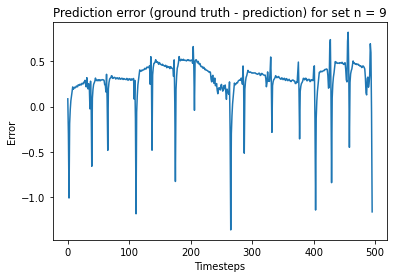

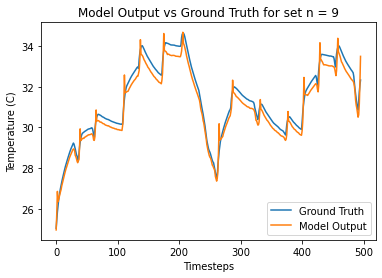

Epoch 11 | Epoch mean training loss for a single simulation = 4.838252742418094
Epoch 11 | Epoch mean test loss for a single simulation = 0.09518303217576636


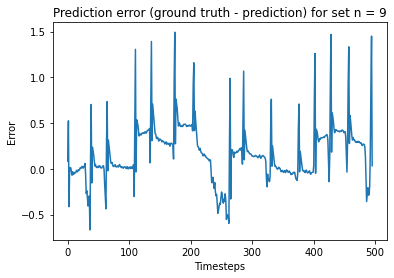

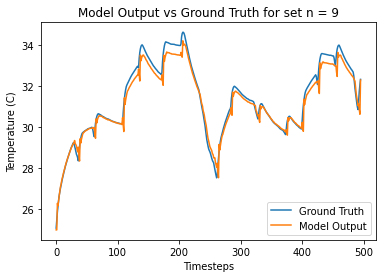

Epoch 12 | Epoch mean training loss for a single simulation = 4.634275978276341
Epoch 12 | Epoch mean test loss for a single simulation = 0.8052583704864034


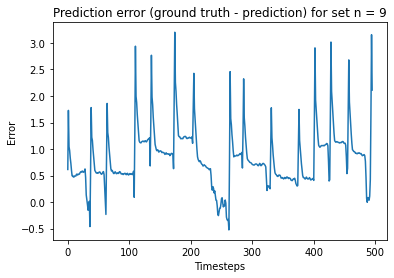

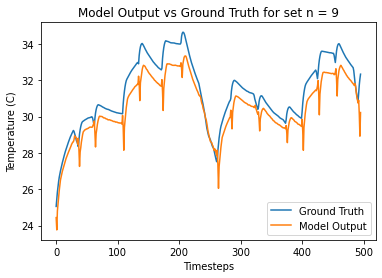

Epoch 13 | Epoch mean training loss for a single simulation = 4.482226416133901
Epoch 13 | Epoch mean test loss for a single simulation = 1.0810246013576212


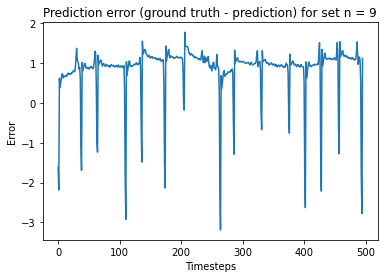

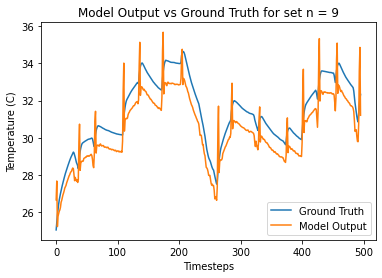

Epoch 14 | Epoch mean training loss for a single simulation = 4.334114575795148
Epoch 14 | Epoch mean test loss for a single simulation = 1.5311493737365853


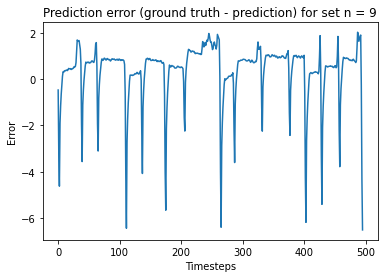

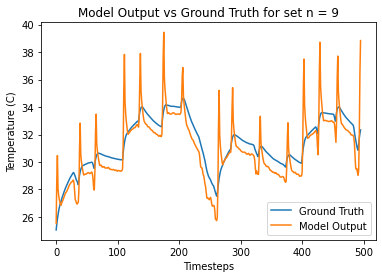

Epoch 15 | Epoch mean training loss for a single simulation = 4.218995654641501
Epoch 15 | Epoch mean test loss for a single simulation = 0.13837233496033735


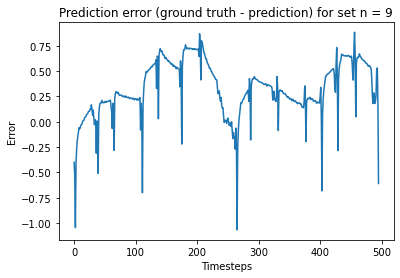

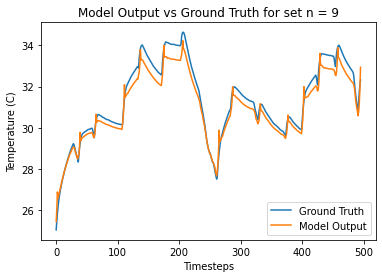

Epoch 16 | Epoch mean training loss for a single simulation = 4.112364670212603
Epoch 16 | Epoch mean test loss for a single simulation = 0.07975558819786285


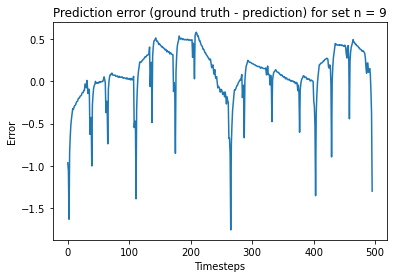

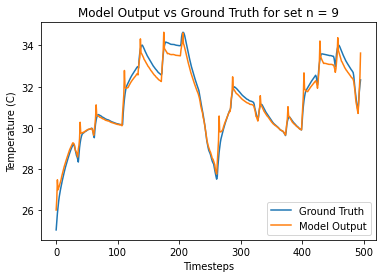

Epoch 17 | Epoch mean training loss for a single simulation = 4.0280405741501015
Epoch 17 | Epoch mean test loss for a single simulation = 0.6077824922471924


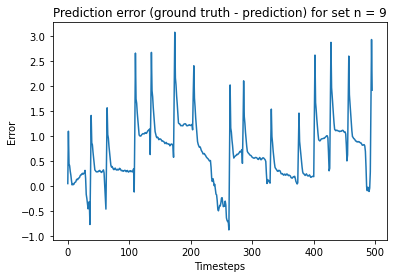

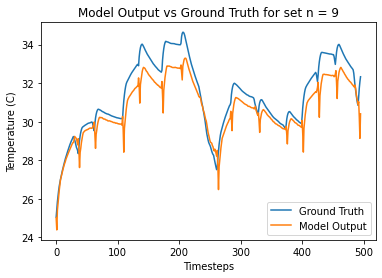

Epoch 18 | Epoch mean training loss for a single simulation = 3.951474886300478
Epoch 18 | Epoch mean test loss for a single simulation = 0.1993145175081032


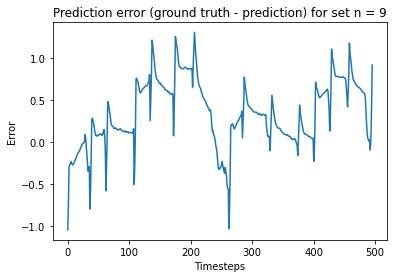

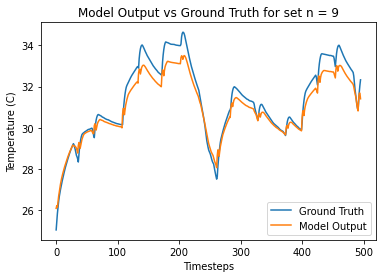

Epoch 19 | Epoch mean training loss for a single simulation = 3.8981401158202673
Epoch 19 | Epoch mean test loss for a single simulation = 0.7239841757537497


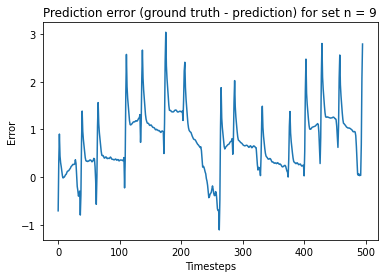

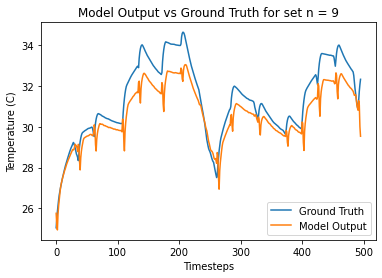

Epoch 20 | Epoch mean training loss for a single simulation = 3.8519454043133883
Epoch 20 | Epoch mean test loss for a single simulation = 0.23264699763366803


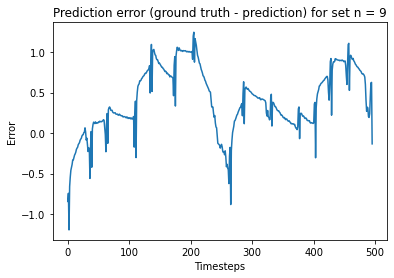

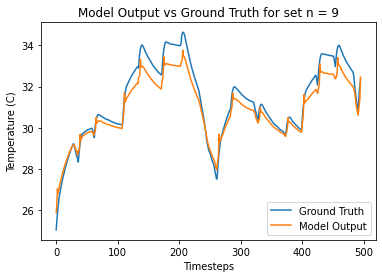

Epoch 21 | Epoch mean training loss for a single simulation = 3.77748935894137
Epoch 21 | Epoch mean test loss for a single simulation = 0.2976764412897248


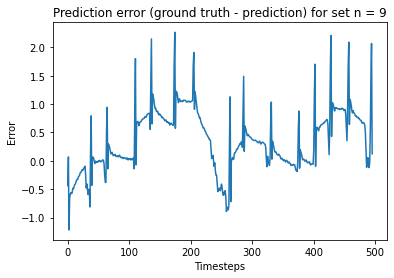

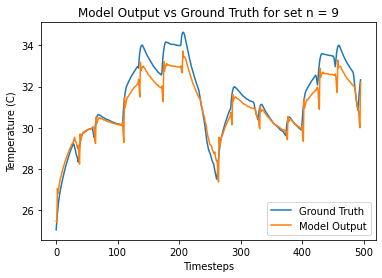

Epoch 22 | Epoch mean training loss for a single simulation = 3.714091762722102
Epoch 22 | Epoch mean test loss for a single simulation = 0.2151271012951545


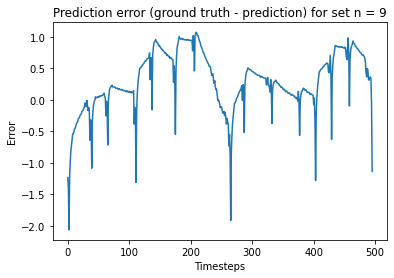

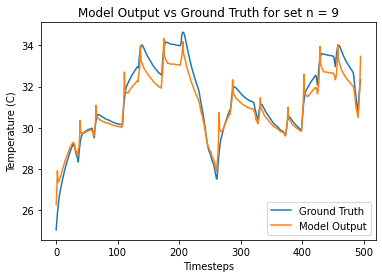

Epoch 23 | Epoch mean training loss for a single simulation = 3.6743932394123178
Epoch 23 | Epoch mean test loss for a single simulation = 0.2689157128227019


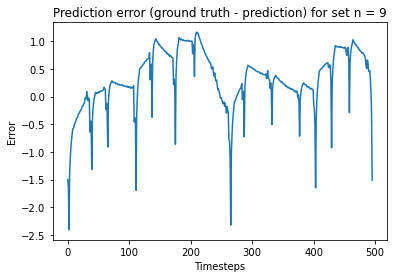

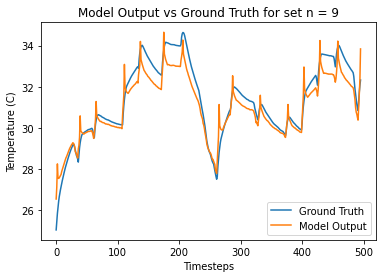

Epoch 24 | Epoch mean training loss for a single simulation = 3.62681122856118
Epoch 24 | Epoch mean test loss for a single simulation = 0.39414184064596836


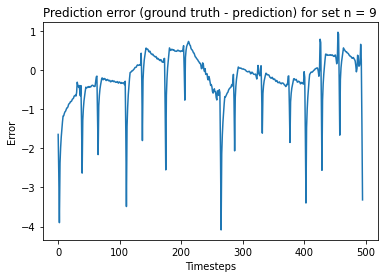

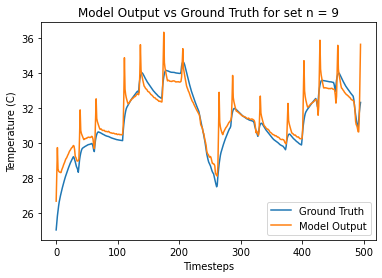

Epoch 25 | Epoch mean training loss for a single simulation = 3.6000208446527706
Epoch 25 | Epoch mean test loss for a single simulation = 0.47921539252950635


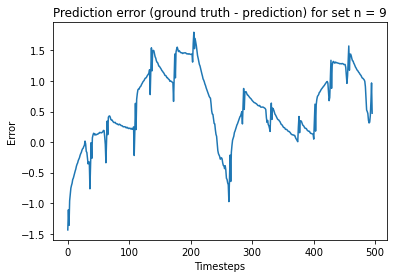

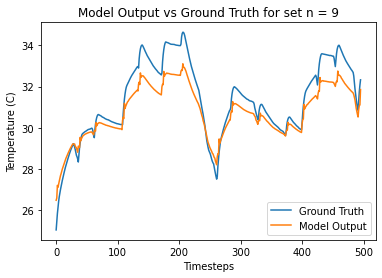

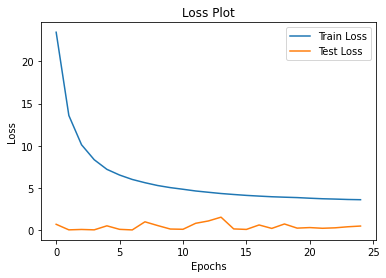

Time per epoch =  1702.5077225875855
Total time =  42562.693064689636


In [7]:
# Initialize the NN
model = NeuralNet(num_hidden_layers = 2, input_size = 8, hidden_size = 25, output_size = 1, dropout_rate = 0.0)#, device = device)
# Train the NN
overall_test_loss_list_one_value_per_epoch, elapsed_time = train_and_test(model, train_data, test_data, optimizer = "Adam", num_epochs = 25)

# Testing the NN

### The following block only needs to be used if new data is needed

In [8]:
# N = 10
# test_solutions_name = str(N) + "test_solutions.npy"
# test_F_ag_array_name = str(N) + "test_F_ag.npy"
# save_dir = "./saved"
# os.makedirs (save_dir, exist_ok=True)


# test_random_inputs = generate_inputs (N)
# test_solutions, test_F_ag_array = generate_ode_data(test_random_inputs, num_timesteps=500)

# print ("="*50)
# print ("Saved: ")
# print (f"{test_solutions_name}: {test_solutions.shape}")
# print (f"{test_F_ag_array_name}: {test_F_ag_array.shape}")
# print ("="*50)

# # SAVE
# np.save (join(save_dir, test_solutions_name), test_solutions)
# np.save (join(save_dir, test_F_ag_array_name), test_F_ag_array)

# # PLOT
# plot_ode_solutions (test_solutions)
# plot_input_output(test_F_ag_array, test_solutions, N)

### Testing the NN

In [9]:
# test(model, test_data)